# Polynomial regression

In [29]:
# NOTE: must have either Gurobi or Mosek installed!

# Instructions on how to install Gurobi: https://github.com/JuliaOpt/Gurobi.jl
# Instructions on how to install Mosek: https://github.com/JuliaOpt/Mosek.jl

# using Pkg
# Pkg.add("Gurobi")
# Pkg.add("Mosek")
# Pkg.add("MosekTools")


In [ ]:
#Pkg.status()

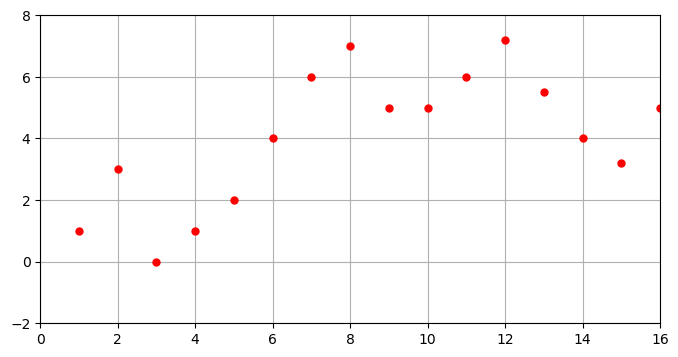

In [31]:
# define (x,y) coordinates of the points
x = [ 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16 ]
y = [ 1, 3, 0, 1, 2, 4, 6, 7, 5, 5, 6, 7.2, 5.5,  4, 3.2, 5]

using PyPlot
figure(figsize=(8,4))
plot(x,y,"r.", markersize=10)
axis([0,16,-2,8])
grid("True")

In [32]:
# Fit the data using a function of the form y = f(x) = u1 x^k + u2 x^(k-1) + ... + uk x + u{k+1}

# Order of polynomial used for fitting
k = 2

# Create the A matrix (where each row corresponds to one observation x_i and each column is an x^k term)
n = length(x)
A = zeros(n,k+1)
for i = 1:n
    for j = 1:k+1
        A[i,j] = x[i]^(k+1-j)
    end
end

In [1]:
# NOTE: must have either Gurobi or Mosek installed!

# Solve the LEAST SQUARES polynomial fit

using JuMP, Gurobi, MosekTools, Mosek

#m = Model(with_optimizer(Gurobi.Optimizer))
#m = Model(with_optimizer(Gurobi.Optimizer,OutputFlag=0))
# m = Model(with_optimizer(Gurobi.Optimizer,NumericFocus=3,BarHomogeneous=1))
#m = Model(with_optimizer(Mosek.Optimizer))
m = Model(with_optimizer(Mosek.Optimizer,LOG=0))

@variable(m, u[1:k+1])
@objective(m, Min, sum( (y - A*u).^2 ) )

optimize!(m)
uopt = value.(u)
println(termination_status(m))
println("The objective value is ", objective_value(m))
println("The optimal parameters are ",uopt)

ArgumentError: ArgumentError: Package Gurobi not found in current path:
- Run `import Pkg; Pkg.add("Gurobi")` to install the Gurobi package.


In [45]:
# Solve the L_1 NORM polynomial fit. 
# Note: We MUST use an LP solver for this! 
# When using the L_1 criterion, there is no equivalent of the normal equations or the backslash command.

using JuMP, Gurobi, MosekTools, Mosek

m = Model(with_optimizer(Gurobi.Optimizer,OutputFlag=0))
#m = Model(with_optimizer(Mosek.Optimizer))

@variable(m, u[1:k+1])
@variable(m, t[1:n] >= 0)
@constraint(m, y-A*u .<= t)
@constraint(m, A*u-y .<= t)
@objective(m, Min, 1/1000*sum(t))

optimize!(m)
uopt_l1 = value.(u)
println(termination_status(m))
println(objective_value(m))
println(uopt_l1)

Academic license - for non-commercial use only
Academic license - for non-commercial use only
OPTIMAL
0.017166666666666663
[-0.03333333333333333, 0.8333333333333333, 0.20000000000000018]


In [46]:
# Compute the LEAST SQUARES fit directly from normal equations

uopt2=inv(A'*A)*(A'*y)
println(uopt2)
residual2=1/1000*sum((y-A*uopt2).^2)

[-0.05674019607843095, 1.241789215686273, -1.1937499999999872]


0.027563223039215684

In [47]:
# Compute the LEAST SQUARES fit from the backslash command

uopt3=A\y

3-element Array{Float64,1}:
 -0.05674019607843127
  1.2417892156862727 
 -1.1937499999999912 

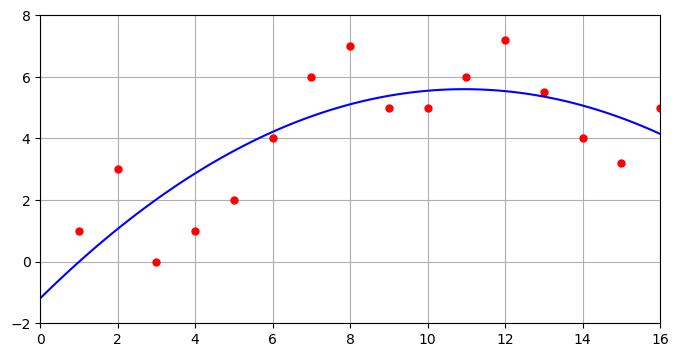

In [52]:
using PyPlot, LinearAlgebra
npts = 100
xfine = range(0,stop=16,length=npts)
ffine = ones(npts)
for j = 1:k
    ffine = [ffine.*xfine ones(npts)]
end
yfine = ffine * uopt
figure(figsize=(8,4))
plot( x, y, "r.", markersize=10)
plot( xfine, yfine, "b-")
axis([0,16,-2,8])
grid()

In [38]:
# NOTE: problem can be solved using ECOS or SCS if written as an "SOCP" --- more on this later!
# Here is a working example:

using JuMP, ECOS, SCS

#m = Model(solver=ECOSSolver(verbose=false))
m = Model(with_optimizer(SCS.Optimizer,verbose=false))

@variable(m, u[1:k+1])
@variable(m, t)
@constraint(m, [t; y - A*u] in SecondOrderCone())
@objective(m, Min, t)

optimize!(m)
uopt = value.(u)
println(termination_status(m))
println(uopt)

OPTIMAL
[-0.056740203897770874, 1.241789475800029, -1.1937498604241117]
